## Introduction - English to French Translation using PyTorch nn.Transformer

French to English translation notebook using PyTorch `nn.Transformer` module.

## Setup (one time)

In [1]:
# !pip install -U portalocker
# !python3 -m spacy download en_core_web_sm
# !python3 -m spacy download fr_core_news_sm

## Imports

In [2]:
%load_ext autoreload
%aimport utils.text_processing
%autoreload 1

In [8]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

from utils.text_processing import TextProcessor
from datasets import load_dataset

import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

/home/marwan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Dataset Preparation

In [5]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'fr'

# Place-holders
token_transform = {}
vocab_transform = {}

In [6]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')

In [7]:
dataset = load_dataset("Nicolas-BZRD/Parallel_Global_Voices_English_French", split='train').to_pandas()
dataset = dataset.sample(n=50000)

max_sequence_length = 20

# truncate the sentences to the max_sequence_length
dataset['en'] = dataset['en'].apply(lambda x: ' '.join(x.split()[:max_sequence_length]))
dataset['fr'] = dataset['fr'].apply(lambda x: ' '.join(x.split()[:max_sequence_length]))

# clean the english and french sentences
dataset['en'] = TextProcessor(dataset, 'en').transform()
dataset['fr'] = TextProcessor(dataset, 'fr').transform()

dataset.head(10)

,en,fr
3129,<start> me what was what <end>,<start> maman qu'est-ce qui se passe <end>
21020,<start> dr congo fighting continues <end>,<start> congo rdc dernieres nouvelles de goma ...
339572,<start> we used our connections and networks t...,<start> nous avons utilise nos relations et re...
142986,<start> and what can be done <end>,<start> comment y remedier <end>
235641,<start> open more local chinese pizza shops th...,<start> ouvrez plus de pizzerias locales chino...
164543,<start> after the french interior ministry sta...,<start> apres les declarations du ministre fra...
124702,<start> along with speculation about a fall in...,<start> a cote des speculations relatives a un...
103919,<start> ug's spores are transported by wind bu...,<start> les spores de l'ug sont disseminees pa...
111782,<start> andrea arzaba from mexico was one of t...,<start> andrea arzaba du mexique etait l'un de...
211261,<start> margee ensign currently president of t...,<start> margee ensign actuellement presidente ...


In [8]:
train_csv, test_csv = train_test_split(dataset, test_size=0.1)

In [9]:
print(len(train_csv))
print(len(test_csv))

45000
5000


In [10]:
train_csv.head()

,en,fr
153654,<start> i know even more about yan wang's sear...,<start> je connais meme encore mieux les metho...
162703,<start> global voices mentors <end>,<start> les tuteurs de global voices <end>
63648,<start> there is a question that i do not have...,<start> il y a une question pour laquelle je n...
61539,<start> perhaps i did miss my own opportunity ...,<start> ou encore vous avez tort et vous n'ave...
291998,<start> the elections are not without controve...,<start> les elections ne vont pas sans controv...


In [11]:
test_csv.head(10)

,en,fr
158893,<start> it has also been confirmed that mark d...,<start> il a egalement ete confirme que mark d...
53763,<start> islandista keeps it simple <end>,<start> islandista reste simple <end>
310949,<start> tajikistan still debating the good and...,<start> au tadjikistan on evalue le pour et le...
179409,<start> the hungry man is an angry manpay the ...,<start> l'homme affame est un homme en colere ...
309057,<start> tell your story share your view debate...,<start> racontez votre histoire partagez votre...
10932,<start> kosovar independence is a prickly ques...,<start> l'independance du kosovo est une quest...
65451,<start> i have lived along katipunan avenue in...,<start> depuis ma naissance je vis le long de ...
1254,<start> rarely does a week pass by without new...,<start> une semaine passe rarement sans que la...
216217,<start> these vultures these vampires who slow...,<start> ces vautours ces vampires qui ponction...
4451,<start> big ones small ones international ones...,<start> des grandes des petites des internatio...


In [12]:
print(train_csv['fr'].iloc[100])
print(train_csv['en'].iloc[100])

<start> que vous ayez fait des plaisanteries idiotes ou montre votre soutien peu importe <end>
<start> if you told stupid jokes or showed your support it does not matter <end>


In [10]:
# Custom Dataset class.
class TranslationDataset(Dataset):
    def __init__(self, csv):
        self.csv = csv
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, idx):
        return(
            self.csv['en'].iloc[idx],
            self.csv['fr'].iloc[idx]
        )

In [14]:
train_dataset = TranslationDataset(train_csv)
valid_dataset = TranslationDataset(test_csv)

In [15]:
iterator = iter(train_dataset)
print(next(iterator))

("<start> i know even more about yan wang's search for minions <end>", '<start> je connais meme encore mieux les methodes de fouille des sbires de yan wang <end>')


In [16]:
# Helper function to yield list of tokens.
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices.
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab.
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Create torchtext's Vocab object.
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_dataset, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [17]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# `src` and `tgt` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

## Model and Training Hyperparameters

In [18]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 192
NHEAD = 6
FFN_HID_DIM = 192
BATCH_SIZE = 16
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = 'cuda'
NUM_EPOCHS = 20

## Prepare Model

In [11]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Inputs of forward function
        :param x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [13]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [14]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1
    ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [23]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS, 
    NUM_DECODER_LAYERS, 
    EMB_SIZE,
    NHEAD, 
    SRC_VOCAB_SIZE, 
    TGT_VOCAB_SIZE, 
    FFN_HID_DIM
).to(DEVICE)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
print(model)

28,259,892 total parameters.
28,259,892 training parameters.
Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=192, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Tr

## Loss function and optimizer.

In [24]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def train_epoch(model, optimizer):
    print('Training')
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader, total=len(list(train_dataloader))):            
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
                
        tgt_input = tgt[:, :-1]
        
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(
            src, 
            tgt_input, 
            src_mask, 
            tgt_mask,
            src_padding_mask, 
            tgt_padding_mask, 
            src_padding_mask
        )

        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def evaluate(model):
    print('Validating')
    model.eval()
    losses = 0

    for src, tgt in tqdm(val_dataloader, total=len(list(val_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        
        tgt_input = tgt[:, :-1]
        
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        
        logits = model(
            src, 
            tgt_input, 
            src_mask, 
            tgt_mask,
            src_padding_mask, 
            tgt_padding_mask, 
            src_padding_mask
        )

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [26]:
train_loss_list, valid_loss_list = [], []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    valid_loss = evaluate(model)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s \n"))

Training


  0%|          | 0/2813 [00:00<?, ?it/s]/home/marwan/.local/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 2813/2813 [01:22<00:00, 34.13it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 66.75it/s]


Epoch: 1, Train loss: 5.186, Val loss: 4.711, Epoch time = 104.157s 

Training


100%|██████████| 2813/2813 [01:19<00:00, 35.21it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 73.13it/s]


Epoch: 2, Train loss: 4.574, Val loss: 4.504, Epoch time = 101.010s 

Training


100%|██████████| 2813/2813 [01:19<00:00, 35.49it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 74.67it/s]


Epoch: 3, Train loss: 4.385, Val loss: 4.419, Epoch time = 99.927s 

Training


100%|██████████| 2813/2813 [01:20<00:00, 35.08it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 72.68it/s]


Epoch: 4, Train loss: 4.265, Val loss: 4.365, Epoch time = 100.723s 

Training


100%|██████████| 2813/2813 [01:20<00:00, 34.78it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 72.43it/s]


Epoch: 5, Train loss: 4.179, Val loss: 4.327, Epoch time = 101.617s 

Training


100%|██████████| 2813/2813 [01:19<00:00, 35.52it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 73.55it/s]


Epoch: 6, Train loss: 4.114, Val loss: 4.294, Epoch time = 99.698s 

Training


100%|██████████| 2813/2813 [01:20<00:00, 35.15it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 72.62it/s]


Epoch: 7, Train loss: 4.055, Val loss: 4.267, Epoch time = 100.654s 

Training


100%|██████████| 2813/2813 [01:19<00:00, 35.44it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 72.95it/s]


Epoch: 8, Train loss: 4.006, Val loss: 4.240, Epoch time = 99.847s 

Training


100%|██████████| 2813/2813 [01:19<00:00, 35.48it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 69.13it/s]


Epoch: 9, Train loss: 3.962, Val loss: 4.224, Epoch time = 100.259s 

Training


100%|██████████| 2813/2813 [01:21<00:00, 34.68it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 71.11it/s]


Epoch: 10, Train loss: 3.921, Val loss: 4.190, Epoch time = 101.954s 

Training


100%|██████████| 2813/2813 [01:18<00:00, 35.93it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 73.65it/s]


Epoch: 11, Train loss: 3.881, Val loss: 4.166, Epoch time = 98.796s 

Training


100%|██████████| 2813/2813 [01:21<00:00, 34.56it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 73.29it/s]


Epoch: 12, Train loss: 3.847, Val loss: 4.144, Epoch time = 102.249s 

Training


100%|██████████| 2813/2813 [01:18<00:00, 35.76it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 75.16it/s]


Epoch: 13, Train loss: 3.813, Val loss: 4.127, Epoch time = 99.109s 

Training


100%|██████████| 2813/2813 [01:20<00:00, 35.01it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 70.60it/s]


Epoch: 14, Train loss: 3.780, Val loss: 4.096, Epoch time = 101.420s 

Training


100%|██████████| 2813/2813 [01:17<00:00, 36.11it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 68.98it/s]


Epoch: 15, Train loss: 3.749, Val loss: 4.072, Epoch time = 98.685s 

Training


100%|██████████| 2813/2813 [01:18<00:00, 35.68it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 72.41it/s]


Epoch: 16, Train loss: 3.721, Val loss: 4.062, Epoch time = 99.500s 

Training


100%|██████████| 2813/2813 [01:18<00:00, 35.79it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 73.47it/s]


Epoch: 17, Train loss: 3.694, Val loss: 4.038, Epoch time = 99.025s 

Training


100%|██████████| 2813/2813 [01:18<00:00, 35.87it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 73.60it/s]


Epoch: 18, Train loss: 3.670, Val loss: 4.027, Epoch time = 99.114s 

Training


100%|██████████| 2813/2813 [01:22<00:00, 34.01it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 72.57it/s]


Epoch: 19, Train loss: 3.649, Val loss: 4.011, Epoch time = 103.556s 

Training


100%|██████████| 2813/2813 [01:19<00:00, 35.34it/s]


Validating


100%|██████████| 313/313 [00:04<00:00, 68.97it/s]


Epoch: 20, Train loss: 3.626, Val loss: 3.995, Epoch time = 101.287s 



## Plots

In [27]:
def save_plots(train_loss, valid_loss):
    """
    Function to save the loss plots to disk.
    """
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

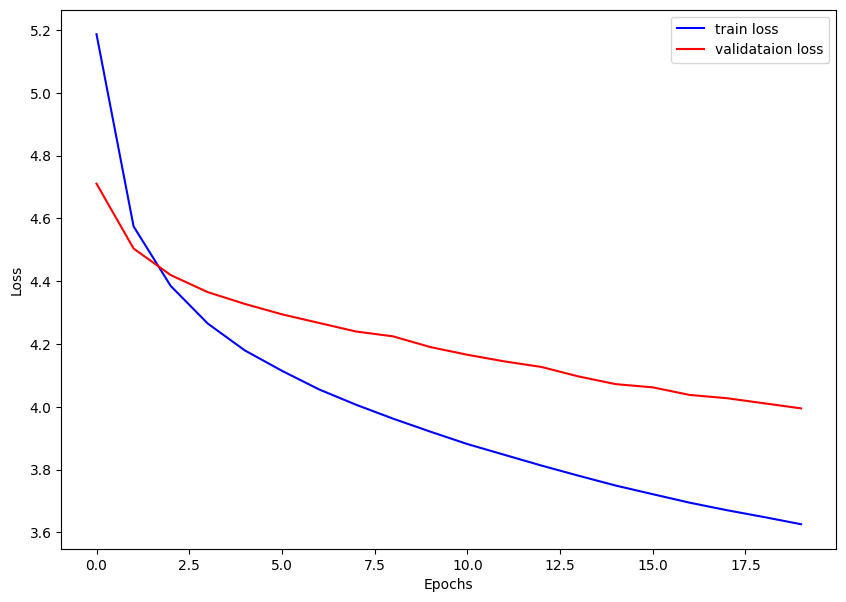

In [28]:
save_plots(train_loss_list, valid_loss_list)

## Save Model

In [29]:
torch.save(model, '../models/eng_fr_nn_transformer.pth')

## Inference

In [15]:
model = torch.load('../models/eng_fr_nn_transformer.pth')

FileNotFoundError: [Errno 2] No such file or directory: '../models/eng_fr_nn_transformer.pth'

In [31]:
# Helper function to generate output sequence using greedy algorithm.
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if i == 0:
            ys = ys.transpose(1, 0)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys

# Translation function. 
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [32]:
# SRC, GT pairs from the validation set.
infer_sentences = [
    ["Take a seat.", "Prends place !"],
    ["I'm not scared to die", "Je ne crains pas de mourir."],
    ["You'd better make sure that it is true.", "Tu ferais bien de t'assurer que c'est vrai."],
    ["The clock has stopped.", "L'horloge s'est arrêtée."],
    ["Take any two cards you like.", "Prends deux cartes de ton choix."]
]

In [6]:
sentence = "The big, red apple fell from the tree and rolled down the hill, making a funny sound as it went. Kids nearby giggled and raced to catch it. The sun shone brightly, warming everyone's faces, while birds chirped happily in the background."
translate(model, [sentence])

NameError: name 'translate' is not defined

In [33]:
for sentence in infer_sentences:
    print(f"SRC: {sentence[0]}")
    print(f"GT: {sentence[1]}")
    print(f"PRED: {translate(model, sentence[0])}\n")

SRC: Take a seat.
GT: Prends place !
PRED:  < start > la journaliste de la journaliste de la

SRC: I'm not scared to die
GT: Je ne crains pas de mourir.
PRED:  < start > la meme si les membres de la police n'

SRC: You'd better make sure that it is true.
GT: Tu ferais bien de t'assurer que c'est vrai.
PRED:  < start > il est important que si que les autres pensent que les russes les

SRC: The clock has stopped.
GT: L'horloge s'est arrêtée.
PRED:  < start > la journaliste de la journaliste a explique que

SRC: Take any two cards you like.
GT: Prends deux cartes de ton choix.
PRED:  < start > vous etes deux comme vous etes deux comme vous etes



In [34]:
from tqdm import tqdm
data = []

references = []
candidates = []

for i in tqdm(range(len(test_csv))):
    context = test_csv['en'].iloc[i]
    reference = test_csv['fr'].iloc[i]
    candidate = translate(model, test_csv['en'].iloc[i])
    
    data.append({
        'Context': context,
        'Reference': reference,
        'Candidate': candidate,
        'length': len(context.split())
    })
    
    references.append([reference])
    candidates.append(candidate)

100%|██████████| 5000/5000 [08:22<00:00,  9.96it/s]


In [35]:
# split into small dataset based on the sentences length
length_ranges = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 30), (31, 40), (41, 60), (61, float('inf'))]

small_datasets = {}
for min_len, max_len in length_ranges:
    filtered_examples = [example for example in data if example['length'] >= min_len and example['length'] <= max_len]
    small_datasets[f'dataset_{min_len}_{max_len}'] = filtered_examples

samples_per_range = []
for key, dataset in small_datasets.items():
    samples_per_range.append(len(dataset))
    print(f"{key}: {len(dataset)} samples")

dataset_1_5: 78 samples
dataset_6_10: 840 samples
dataset_11_15: 887 samples
dataset_16_20: 929 samples
dataset_21_30: 2266 samples
dataset_31_40: 0 samples
dataset_41_60: 0 samples
dataset_61_inf: 0 samples


In [36]:
from nltk.translate.bleu_score import corpus_bleu

def compute_corpus_bleu(references, candidates):
    if len(references) != len(candidates):
        raise ValueError('The number of references and candidates must be the same :', len(references), len(candidates))
    
    if len(references) == 0: return 0.0
    
    reference_tokens = [[ref] for ref in references]
    return corpus_bleu(reference_tokens, candidates)

In [37]:
bleu_scores = []
for key, dataset in small_datasets.items():
    refs = [example['Reference'] for example in dataset]
    cands = [example['Candidate'] for example in dataset]
    
    corpus_bleu_score = compute_corpus_bleu(refs, cands)
    bleu_scores.append(corpus_bleu_score)
    
    print(f"{key}: {corpus_bleu_score:.4f}")

dataset_1_5: 0.3034
dataset_6_10: 0.3532
dataset_11_15: 0.3545
dataset_16_20: 0.3467
dataset_21_30: 0.3416
dataset_31_40: 0.0000
dataset_41_60: 0.0000
dataset_61_inf: 0.0000


In [38]:
overall_bleu_score = corpus_bleu(references, candidates)
overall_bleu_score

0.3466771030416517

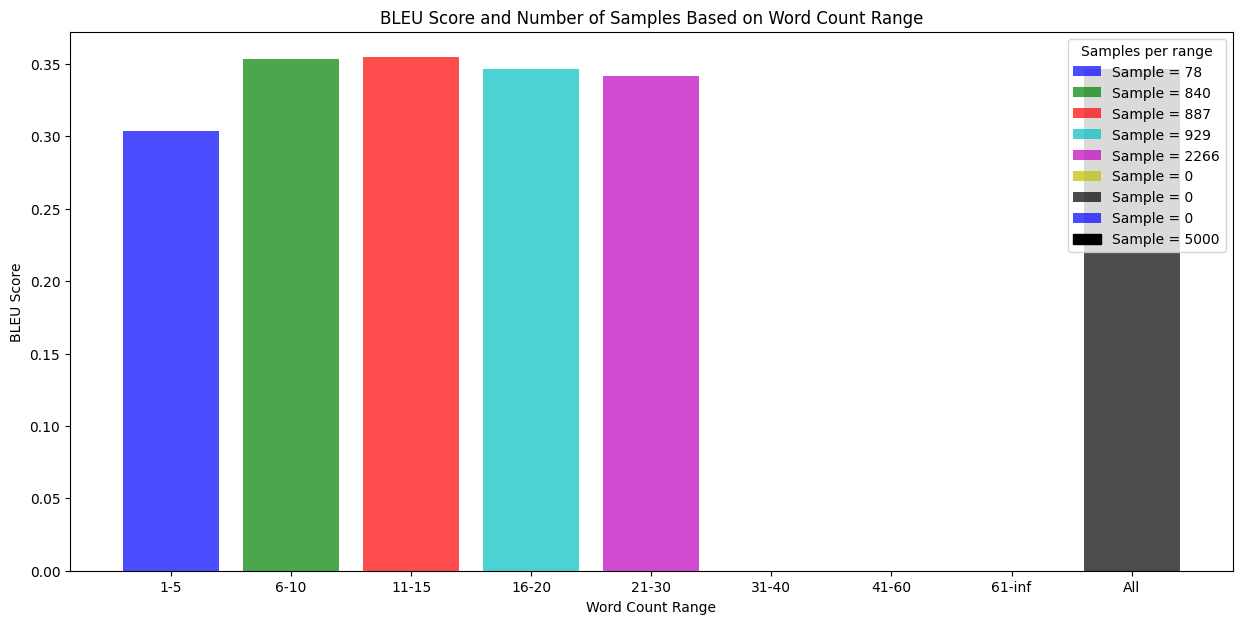

In [5]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors for each bar
bar_plot = plt.bar([f'{start}-{end}' for start, end in length_ranges], bleu_scores, color=colors, alpha=0.7, label='BLEU Score')

# Add "All" bar with legend
all_bar = plt.bar("All", overall_bleu_score, color='k', alpha=0.7)

# Create a dummy handle for the "All" bar
all_patch = mpatches.Patch(color='k', label=f'Sample = {len(candidates)}')
legend_labels = [f'Sample = {value}' for value in samples_per_range]

# Include the dummy handle in the legend
plt.legend(handles=[*bar_plot, all_patch], labels=legend_labels + [f'Sample = {len(candidates)}'], loc='upper right', title='Samples per range')

plt.xlabel('Word Count Range')
plt.ylabel('BLEU Score')

plt.title('BLEU Score and Number of Samples Based on Word Count Range')

plt.show()